In [57]:
# Import necessary libraries for data manipulation and analysis
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
from datetime import datetime, timedelta # Date operations

#Import necessary libraries for transformations
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt # Matplotlib for basic plotting
import seaborn as sns # Seaborn for enhanced visualization
import plotly.express as px # Plotly for interactive plots

# Import libraries for time series analysis and modeling
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test for stationarity check
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin Test for stationarity check
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX model for time series forecasting
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition for trend, seasonal, and residual components
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.Sarimax import Sarimax
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima #SARIMAX using pmdarima
from skforecast.ForecasterSarimax import ForecasterSarimax

# Import necessary libraries for computing acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from statsmodels.tsa.stattools import acf, pacf  # For computing autocorrelation and partial autocorrelation

import joblib



SARIMAX for Visayas
DATA PREPROCESSING

In [23]:
labels_csv = r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Visayas/train_labels_transformed.csv'
data_csv = r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Visayas/train_data_transformed.csv'
test_data_csv=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Visayas/test_data.csv'
test_labels_csv=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Visayas/test_labels.csv'
transformed_data=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Visayas/data_transformed.csv'
complete_data = '/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Visayas/VIS_Daily_Complete.csv'

transformed_train_data = pd.read_csv(data_csv)
transformed_train_labels = pd.read_csv(labels_csv)
transformed_data = pd.read_csv(transformed_data)

test_data = pd.read_csv(test_data_csv)
test_labels = pd.read_csv(test_labels_csv)

complete_data_df = pd.read_csv(complete_data)
gwap = complete_data_df[['GWAP']]
lwap = complete_data_df[['LWAP']]



In [24]:
train_size = int(len(transformed_train_labels))  
test_size = int(len(test_data))

date_range = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
date_df = pd.DataFrame(date_range, columns=['Date'])

train_date = date_df[:train_size]
test_date = date_df[train_size:]

#Resetting the Index
train_date = train_date.reset_index(drop=True)
test_date = test_date.reset_index(drop=True)


In [25]:
#Preparing the dataframes
transformed_train_labels.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)
labels_columns = ['GWAP', 'LWAP']
labels_train = pd.DataFrame(transformed_train_labels, columns = labels_columns)
labels_test = pd.DataFrame(test_labels, columns = labels_columns)

transformed_train_data.rename(columns={'0':'FLOW_VIS', '1':'TMIN_Catbalogan', '2':'TMAX_Roxas City','3':'TMIN_Roxas City','4':'TMAX_Catarman','5':'TMIN_Catarman','6':'TMAX_Maasin','7':'TMIN_Maasin','8':'TMAX_Dumaguete', '9':'TMIN_Dumaguete', '10':'GWAP','11':'LWAP','12':'Hourly Demand','13':'TMAX_Catbalogan','14':'RESERVE_GWAP_Fr','15':'RESERVE_GWAP_Ru','16':'RESERVE_GWAP_Rd','17':'RESERVE_GWAP_Dr','18':'RAINFALL_Catbalogan','19':'RAINFALL_Roxas City','20':'RAINFALL_Catarman','21':'RAINFALL_Maasin','22':'RAINFALL_Dumaguete'}, inplace=True)
data_columns = ['FLOW_VIS', 'TMIN_Catbalogan', 'TMAX_Roxas City', 'TMIN_Roxas City', 'TMAX_Catarman', 'TMIN_Catarman', 'TMAX_Maasin', 'TMIN_Maasin', 'TMAX_Dumaguete', 'TMIN_Dumaguete','GWAP', 'LWAP', 'Hourly Demand', 'TMAX_Catbalogan','RESERVE_GWAP_Fr', 'RESERVE_GWAP_Ru', 'RESERVE_GWAP_Rd', 'RESERVE_GWAP_Dr', 'RAINFALL_Catbalogan', 'RAINFALL_Roxas City', 'RAINFALL_Catarman', 'RAINFALL_Maasin', 'RAINFALL_Dumaguete']
data_train = pd.DataFrame(transformed_train_data, columns = data_columns)
data_test = pd.DataFrame(test_data, columns = data_columns)

transformed_data.rename(columns={'0':'FLOW_VIS', '1':'TMIN_Catbalogan', '2':'TMAX_Roxas City','3':'TMIN_Roxas City','4':'TMAX_Catarman','5':'TMIN_Catarman','6':'TMAX_Maasin','7':'TMIN_Maasin','8':'TMAX_Dumaguete', '9':'TMIN_Dumaguete', '10':'GWAP','11':'LWAP','12':'Hourly Demand','13':'TMAX_Catbalogan','14':'RESERVE_GWAP_Fr','15':'RESERVE_GWAP_Ru','16':'RESERVE_GWAP_Rd','17':'RESERVE_GWAP_Dr','18':'RAINFALL_Catbalogan','19':'RAINFALL_Roxas City','20':'RAINFALL_Catarman','21':'RAINFALL_Maasin','22':'RAINFALL_Dumaguete'}, inplace=True)

In [26]:
#lagging the transformed data
transformed_data = transformed_data.shift(1)
transformed_data = transformed_data.fillna(0)

#Removing GWAP and LWAP
transformed_exog = transformed_data.drop(columns=['GWAP','LWAP'])

#Preparing the exog datasets
train_exog = transformed_exog[:train_size]
test_exog = transformed_exog[train_size:]



In [27]:
#Preparing transformed GWAP datasets
GWAP_train = labels_train['GWAP']
GWAP_train = pd.concat([train_date,GWAP_train], axis=1)
GWAP_train.set_index('Date', inplace=True)
GWAP_train.index = pd.to_datetime(GWAP_train.index)
GWAP_train.index.freq='D'
GWAP_train = GWAP_train.squeeze()


GWAP_test = labels_test['GWAP']
GWAP_test = pd.concat([test_date,GWAP_test], axis=1)
GWAP_test.set_index('Date', inplace=True)
GWAP_test.index = pd.to_datetime(GWAP_test.index)
GWAP_test.index.freq='D'
GWAP_test = GWAP_test.squeeze()

#Preparing original GWAP datasets
GWAP = pd.concat([date_df,gwap], axis=1)
GWAP.set_index('Date', inplace=True)
GWAP.index = pd.to_datetime(GWAP.index)
GWAP.index.freq='D'
GWAP = GWAP.squeeze()

GWAP_test_inversed = GWAP[train_size:]




#Preparing the transformed LWAP datasets
LWAP_train = labels_train['LWAP']
LWAP_train = pd.concat([train_date,LWAP_train], axis=1)
LWAP_train.set_index('Date', inplace=True)
LWAP_train.index = pd.to_datetime(LWAP_train.index)
LWAP_train.index.freq='D'
LWAP_train = LWAP_train.squeeze()

LWAP_test = labels_test['LWAP']
LWAP_test = pd.concat([test_date,LWAP_test], axis=1)
LWAP_test.set_index('Date', inplace=True)
LWAP_test.index = pd.to_datetime(LWAP_test.index)
LWAP_test.index.freq='D'
LWAP_test = LWAP_test.squeeze()

#Preparing the original LWAP datasets

LWAP = pd.concat([date_df,lwap], axis=1)
LWAP.set_index('Date', inplace=True)
LWAP.index = pd.to_datetime(LWAP.index)
LWAP.index.freq='D'
LWAP = LWAP.squeeze()

LWAP_test_inversed = LWAP[train_size:]



#Preparing the exogenous datasets
exog_train = pd.concat([train_date,train_exog], axis=1)
exog_train.set_index('Date', inplace=True)

test_exog = pd.DataFrame(test_exog)
test_exog = test_exog.reset_index()
exog_test = pd.concat([test_date,test_exog], axis=1)
exog_test.set_index('Date', inplace=True)
exog_test = exog_test.drop(columns=['index'])

In [28]:
#Plotting Train LWAP ang GWAP
# Create the line plot
gwap_plot = px.line(GWAP_train, x=GWAP_train.index, y='GWAP')
lwap_plot = px.line(LWAP_train, x=LWAP_train.index, y='LWAP')
# Set the title using the ticker value
gwap_plot.update_layout(title=f"Visayas GWAP")
lwap_plot.update_layout(title=f"Visayas LWAP")
# Display the plot
gwap_plot.show()
lwap_plot.show()

In [29]:
def perform_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Check initial stationarity
    for i in range(max_differences):
        adf_p_value = adf_test(data)
        kpss_p_value = kpss_test(data)

        # If ADF p-value is less than 0.05 and KPSS p-value is greater than 0.05, it's stationary
        if adf_p_value < 0.05 and kpss_p_value > 0.05:
            print(f"Data is stationary after differencing {i} times.")
            return data

        # If not stationary, apply differencing
        data = data.diff().dropna()

    print(f"Data could not be made stationary after {max_differences} differencing operations.")
    return data

#same test for dataframe
def perform_df_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS 
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Store in new DataFrame
    diff_exog = pd.DataFrame(index=data.index)

    # Check each column in the DataFrame
    for column in data.columns:
        series = data[column].copy()  # Copy the series to avoid modifying the original

        for i in range(max_differences):
            adf_p_value = adf_test(series)
            kpss_p_value = kpss_test(series)

            # If stationary, break the loop and store the series
            if adf_p_value < 0.05 and kpss_p_value > 0.05:
                print(f"Column '{column}' is stationary after differencing {i} times.")
                diff_exog[column] = series  # Store the stationary series
                break

            # If not stationary, apply differencing
            if i < max_differences - 1:  # Don't drop NA on the last iteration
                series = series.diff().dropna()

        else:  # This else corresponds to the for-loop
            print(f"Column '{column}' could not be made stationary after {max_differences} differencing operations.")
            diff_exog[column] = series  # Store the last differenced result

    return diff_exog


In [30]:
#Checking for stationarity in GWAP data
perform_differencing(GWAP_train)
perform_differencing(LWAP_train)



Data is stationary after differencing 0 times.
Data is stationary after differencing 0 times.


Date
2022-01-01    0.000501
2022-01-02    0.000000
2022-01-03    0.218610
2022-01-04    0.153859
2022-01-05    0.247301
                ...   
2023-08-03    0.431814
2023-08-04    0.570586
2023-08-05    0.468382
2023-08-06    0.465701
2023-08-07    0.483897
Freq: D, Name: LWAP, Length: 584, dtype: float64

In [31]:
diff_exog_train = perform_df_differencing(exog_train)
diff_exog_train = diff_exog_train.fillna(0)

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned

Column 'FLOW_VIS' is stationary after differencing 0 times.
Column 'TMIN_Catbalogan' is stationary after differencing 0 times.
Column 'TMAX_Roxas City' is stationary after differencing 1 times.
Column 'TMIN_Roxas City' is stationary after differencing 1 times.
Column 'TMAX_Catarman' is stationary after differencing 1 times.
Column 'TMIN_Catarman' is stationary after differencing 1 times.
Column 'TMAX_Maasin' is stationary after differencing 1 times.
Column 'TMIN_Maasin' is stationary after differencing 1 times.
Column 'TMAX_Dumaguete' is stationary after differencing 1 times.
Column 'TMIN_Dumaguete' is stationary after differencing 0 times.
Column 'Hourly Demand' is stationary after differencing 1 times.
Column 'TMAX_Catbalogan' is stationary after differencing 0 times.
Column 'RESERVE_GWAP_Fr' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Ru' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Rd' is stationary after differencing 1 times.
Column 'RESERVE_GW

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned

In [33]:
diff_exog_test = perform_df_differencing(exog_test)
diff_exog_test = diff_exog_test.fillna(0)


Column 'FLOW_VIS' is stationary after differencing 1 times.
Column 'TMIN_Catbalogan' is stationary after differencing 1 times.
Column 'TMAX_Roxas City' is stationary after differencing 1 times.
Column 'TMIN_Roxas City' is stationary after differencing 1 times.
Column 'TMAX_Catarman' is stationary after differencing 1 times.
Column 'TMIN_Catarman' is stationary after differencing 1 times.
Column 'TMAX_Maasin' is stationary after differencing 0 times.
Column 'TMIN_Maasin' is stationary after differencing 1 times.
Column 'TMAX_Dumaguete' is stationary after differencing 1 times.
Column 'TMIN_Dumaguete' is stationary after differencing 2 times.
Column 'Hourly Demand' is stationary after differencing 0 times.
Column 'TMAX_Catbalogan' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Fr' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Ru' is stationary after differencing 0 times.
Column 'RESERVE_GWAP_Rd' is stationary after differencing 0 times.
Column 'RESERVE_GW

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_2654/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned

In [34]:
#Checking GWAP for seasonality
from scipy.stats import kruskal

GWAP_train_weekly=pd.DataFrame(GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
GWAP_train_weekly['day_of_week'] = GWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_GWAP_train_weekly = [group['GWAP'].values for name, group in GWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_GWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

Kruskal-Wallis test statistic: 25.319065745646412
p-value: 0.00029798735618962894
There are significant differences between the weekly groups.


In [35]:
#Checking LWAP for seasonality
LWAP_train_weekly=pd.DataFrame(GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
LWAP_train_weekly['day_of_week'] = LWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_LWAP_train_weekly = [group['GWAP'].values for name, group in LWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_LWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

Kruskal-Wallis test statistic: 25.319065745646412
p-value: 0.00029798735618962894
There are significant differences between the weekly groups.


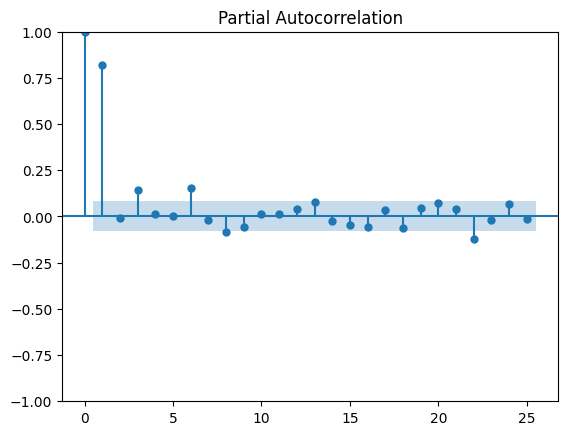

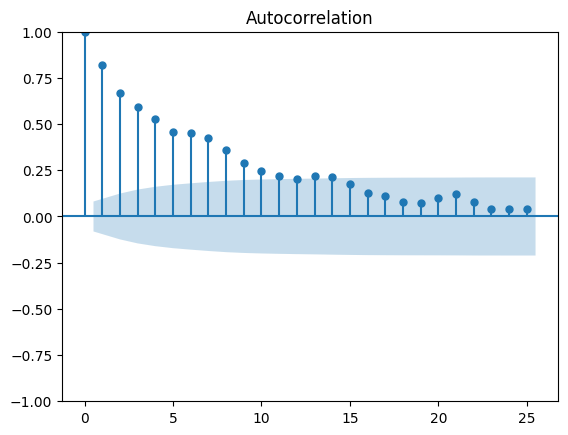

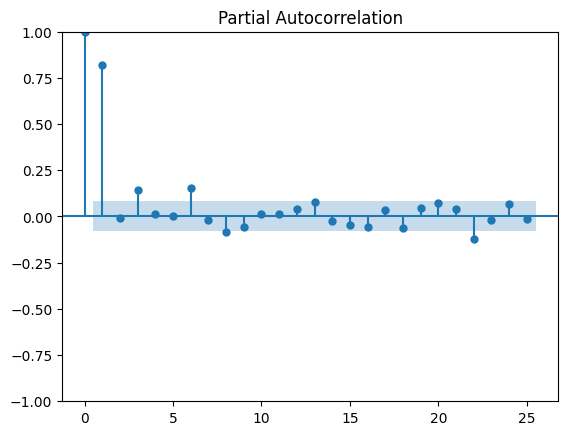

In [36]:
# Visualize autocorrelation using plot_acf
plot_acf(GWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(GWAP_train, lags=25, alpha=0.05)

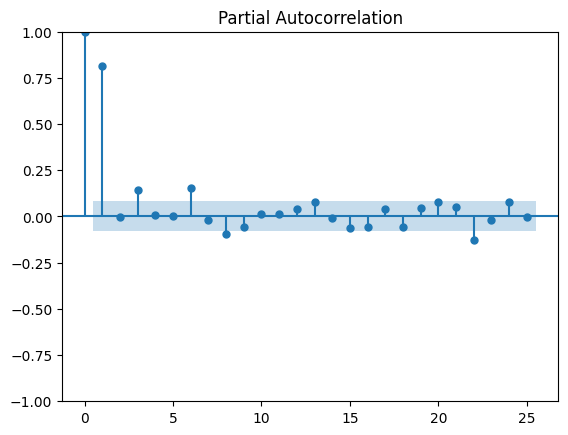

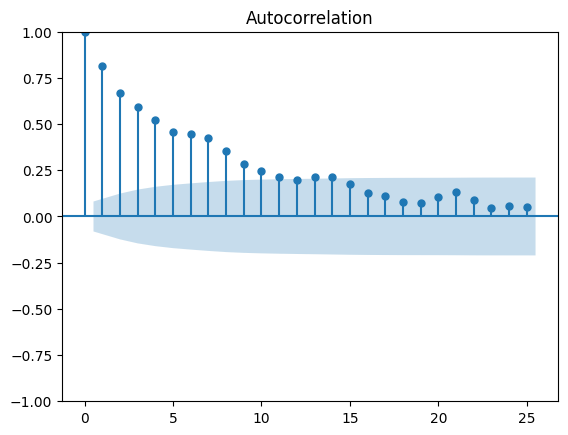

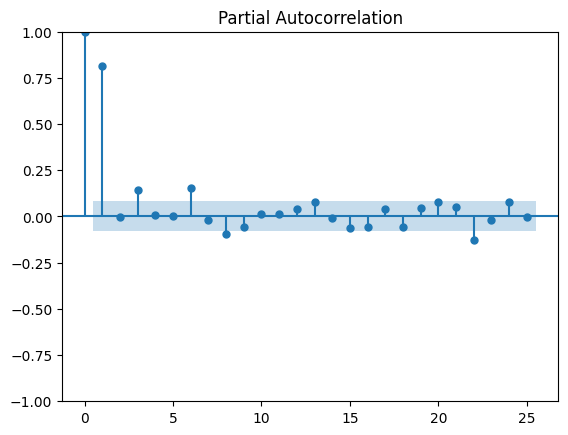

In [38]:

# Visualize autocorrelation using plot_acf
plot_acf(LWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(LWAP_train, lags=25, alpha=0.05)

Forecast using statsmodels

In [75]:
#weekly seasonality
GWAP_sarimax_7 = auto_arima(GWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=10, seasonal=True, m=7, start_P=0, start_D=0, start_Q=0,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=diff_exog_train, iter=1000, method='powell')

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1261.984, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-1270.064, Time=0.33 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-1269.496, Time=0.79 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-1271.397, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-1272.987, Time=0.28 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-1267.994, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1276.761, Time=0.18 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-1276.572, Time=0.86 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-1278.340, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(0,1,1)(2,0,0)[7] interce

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -1.169525
         Iterations: 11
         Function evaluations: 2567


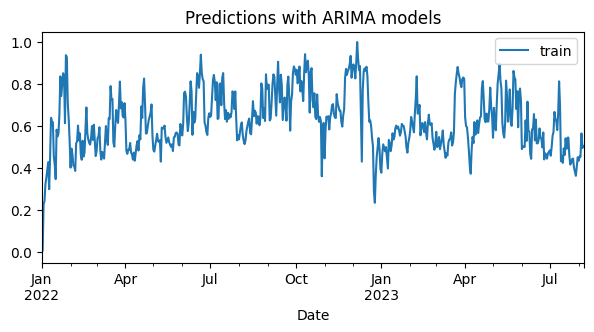

In [76]:
#Using statsmodels

gwap_model_weekly = SARIMAX(endog = GWAP_train, exog = diff_exog_train, order=(1, 1, 1), seasonal_order=(2,0,0,7))
fitted_gwap_model_weekly=gwap_model_weekly.fit(method='powell', maxiter=300)

gwap_train_predict = fitted_gwap_model_weekly.predict(start='2022-01-01', end='2023-08-07', exog=diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



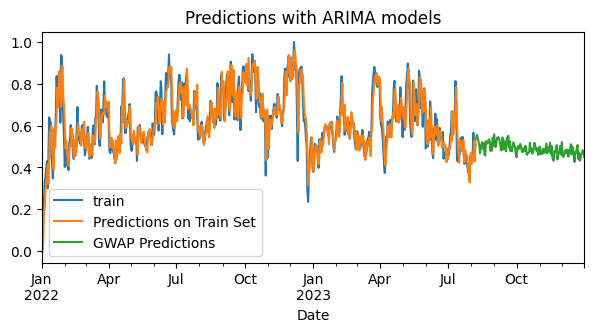

In [43]:
gwap_test_predict = fitted_gwap_model_weekly.predict(start='2023-8-8', end='2023-12-31', exog=diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
gwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
gwap_test_predict.plot(ax=ax, label='GWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [77]:
LWAP_sarimax_7 = auto_arima(LWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=14, seasonal=True, m=7, start_P=0, start_D=0, start_Q=0,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=diff_exog_train, iter=1000, method='powell')

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1156.763, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-1165.191, Time=4.62 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-1165.283, Time=6.46 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-1166.844, Time=5.86 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=32.67 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=3.65 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-1169.890, Time=0.50 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=23.52 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-1164.534, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1173.681, Time=5.65 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-1174.162, Time=6.09 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-1175.584, Time=5.92 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=34.70 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=61.45 sec
 ARIMA(0,1,1)(2,0,0)[7] int

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -1.084456
         Iterations: 12
         Function evaluations: 2795


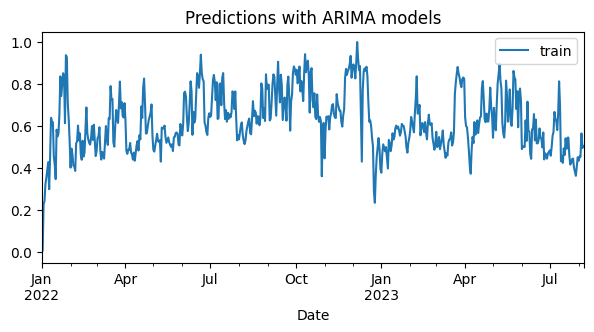

In [78]:
lwap_model_weekly = SARIMAX(endog = LWAP_train, exog = diff_exog_train, order=(1, 1, 1), seasonal_order=(2,0,0,7))
fitted_lwap_model_weekly=lwap_model_weekly.fit(method='powell', maxiter=300)
#Check fit on train set
lwap_train_predict = fitted_lwap_model_weekly.predict(start='2022-01-01', end='2023-08-07', exog=diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
LWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

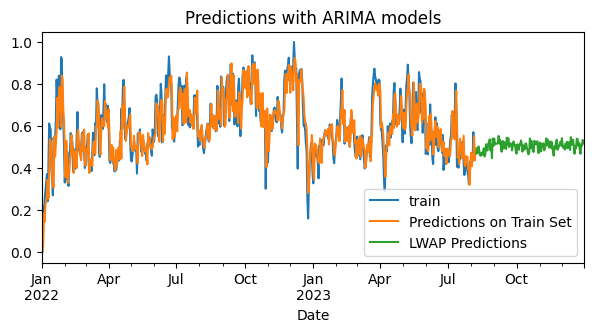

In [79]:
#Predict using LWAP mdodel and plot predictions
lwap_test_predict = fitted_lwap_model_weekly.predict(start='2023-8-8', end='2023-12-31', exog=diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
LWAP_train.plot(ax=ax, label='train')
lwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
lwap_test_predict.plot(ax=ax, label='LWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

Rolling Forecast

In [60]:

def rolling_forecast(train, test, exog_train, exog_test, order, season):
    """
    Perform rolling forecast with SARIMAX model, including exogenous variables.
    
    Parameters:
    - train: Series or DataFrame containing the target variable for training.
    - test: Series or DataFrame containing the target variable for testing.
    - exog_train: DataFrame containing the exogenous variables for training.
    - exog_test: DataFrame containing the exogenous variables for testing.
    - order: Tuple (p, d, q) representing the AR, I, and MA terms.
    - season: Tuple (P, D, Q, S) representing the seasonal AR, I, and MA terms with the seasonal period.
    
    Returns:
    - results: Dictionary containing predictions, mse, rmse, and mae.
    """
    history = [x for x in train]  # Start with training data
    exog_history = exog_train.iloc[0:len(train)]  # Corresponding exogenous data for training
    model = SARIMAX(history, exog=exog_history, order=order, seasonal_order=season)
    model_fit = model.fit(disp=False, method='powell', maxiter=300)
    
    predictions = []
    results = {}
    
    # First forecast (out of sample) using the first test point
    exog_forecast = exog_test.iloc[0:1]  # First test point's exogenous variables
    yhat = model_fit.forecast(exog=exog_forecast)[0]
    
    predictions.append(yhat)
    history.append(test[0])  # Add the first test observation to the history
    exog_history = pd.concat([exog_history, exog_test.iloc[0:1]])  # Use concat instead of append
    
    # Rolling forecast loop
    for i in range(1, len(test)):
        model = SARIMAX(history, exog=exog_history, order=order, seasonal_order=season)
        model_fit = model.fit(disp=False, method='powell', maxiter=300)
        
        exog_forecast = exog_test.iloc[i:i+1]  # Current test point exogenous variables
        yhat = model_fit.forecast(exog=exog_forecast)[0]
        
        predictions.append(yhat)
        
        obs = test[i]  # Actual test value
        history.append(obs)  # Append to history
        
        # Concatenate new exogenous data with history
        exog_history = pd.concat([exog_history, exog_test.iloc[i:i+1]])  # Use concat instead of append
    
    # Calculate error metrics
    rmse = mean_squared_error(test, predictions,squared=False)
    mae = mean_absolute_error(test, predictions)
    
    # Convert predictions to a pandas Series
    predictions = pd.Series(predictions, index=test.index)
    
    # Store results
    results['predictions'] = predictions
    results['rmse'] = rmse
    results['mae'] = mae
    
    return results

In [61]:
gwap_rolling_predictions = rolling_forecast(GWAP_train, GWAP_test, diff_exog_train, diff_exog_test, order=(1, 1, 1), season=(1,0,0,7))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [ ]:
lwap_rolling_predictions = rolling_forecast(LWAP_train, LWAP_test, diff_exog_train, diff_exog_test, order=(1, 1, 1), season=(1,0,0,7))

Applying inverse transformations - non-rolling

In [80]:
#Applying the inverse transformations
#Loading inverse transformations for Visayas

minmax_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Visayas/minmax_scaler.pkl')
boxcox_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Visayas/boxcox_pipeline.pkl')
yeojohnson_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Visayas/yeojohnson_pipeline.pkl')
boxcoxy_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Visayas/boxcox_pipeliney.pkl')

In [81]:
all_predictions = pd.concat([gwap_test_predict, lwap_test_predict], axis=1)
all_predictions_inverse=boxcoxy_fit_loaded.inverse_transform(all_predictions)
all_predictions_inverse

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but PowerTransformer was fitted with feature names



array([[6074.21182001, 5684.12960107],
       [6522.09124601, 6245.15410301],
       [6008.57440344, 5747.58239157],
       [5679.16235534, 6432.11921581],
       [5302.45069031, 5928.14067688],
       [4507.52025915, 5498.84255021],
       [5026.79177457, 5462.0326206 ],
       [5388.49755278, 5735.26217692],
       [5615.31276514, 5783.8055821 ],
       [4904.13900284, 5547.95053364],
       [5562.46606447, 6222.27556999],
       [4367.64516682, 5400.95610885],
       [4302.56787619, 5556.11153377],
       [5755.12354794, 6679.10197567],
       [5573.44653701, 6118.01082479],
       [5474.77542438, 5978.28780239],
       [5779.84784519, 6797.43825639],
       [5948.53138134, 6800.95715523],
       [5717.2145275 , 7286.04080607],
       [4729.57722396, 6001.41709005],
       [5557.57282207, 6638.00225322],
       [4745.31145401, 5249.9340381 ],
       [6169.0816802 , 7373.15601192],
       [5221.51383572, 6528.76170006],
       [6599.21080463, 7421.47790275],
       [5226.24567233, 66

In [82]:
all_predictions_inverse_df = pd.DataFrame(all_predictions_inverse)
all_predictions_inverse_df.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)

GWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 0], columns=['GWAP'])
GWAP_predictions_inverse = pd.concat([test_date,GWAP_predictions_inverse], axis=1)
GWAP_predictions_inverse.set_index('Date', inplace=True)
GWAP_predictions_inverse.index = pd.to_datetime(GWAP_predictions_inverse.index)
GWAP_predictions_inverse.index.freq='D'
GWAP_predictions_inverse = GWAP_predictions_inverse.squeeze()

LWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 1], columns=['LWAP'])
LWAP_predictions_inverse = pd.concat([test_date,LWAP_predictions_inverse], axis=1)
LWAP_predictions_inverse.set_index('Date', inplace=True)
LWAP_predictions_inverse.index = pd.to_datetime(LWAP_predictions_inverse.index)
LWAP_predictions_inverse.index.freq='D'
LWAP_predictions_inverse = LWAP_predictions_inverse.squeeze()

Mean Absolute Error (MAE) on Test Set: 2037.9391123777716
Root Mean Squared Error (RMSE) on Test Set: 3310.2884441189267


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



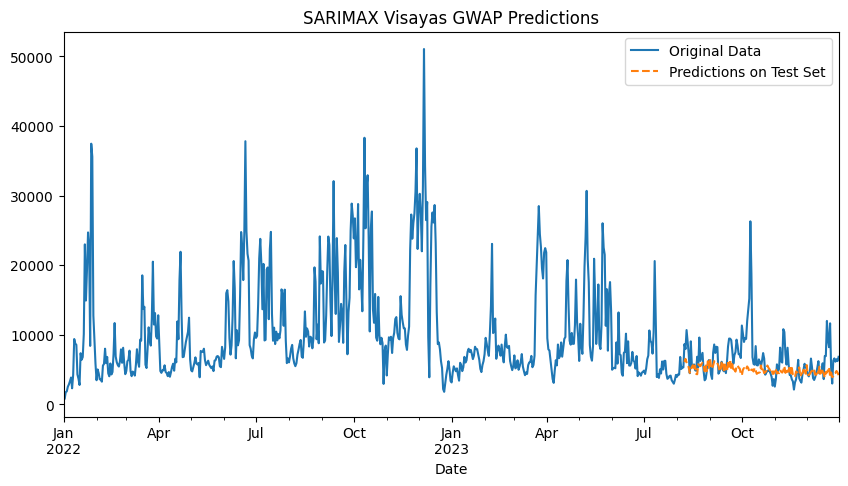

In [85]:
# Calculate MAE for the Visayas GWAP test set
mae_test = mean_absolute_error(GWAP_test_inversed, GWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Visayas GWAP test set
rmse_test = mean_squared_error(GWAP_test_inversed, GWAP_predictions_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
GWAP.plot(ax=ax, label='Original Data')
GWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Visayas GWAP Predictions')
ax.legend()
plt.show()

Mean Absolute Error (MAE) on Test Set: 2208.8213978015883
Root Mean Squared Error (RMSE) on Test Set: 3282.5132426588807


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



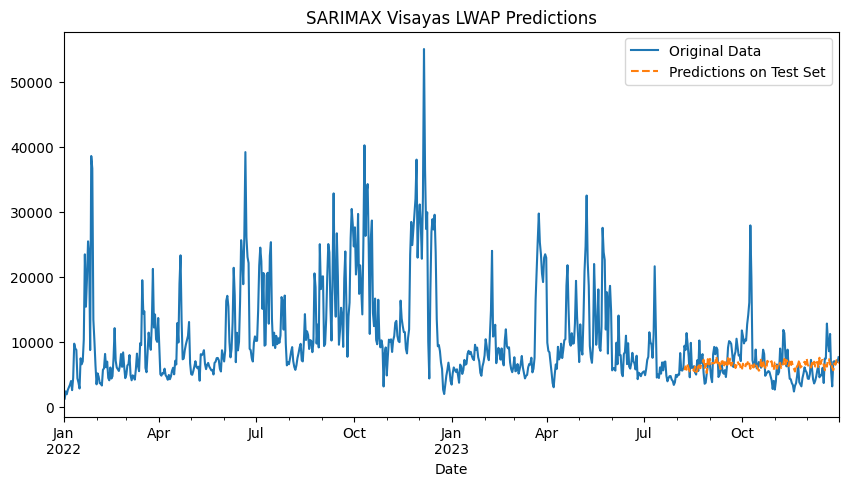

In [86]:
# Calculate MAE for the Visayas LWAP test set
mae_test = mean_absolute_error(LWAP_test_inversed, LWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Visayas GWAP test set
rmse_test = mean_squared_error(LWAP_test_inversed, LWAP_predictions_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original Data')
LWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Visayas LWAP Predictions')
ax.legend()
plt.show()

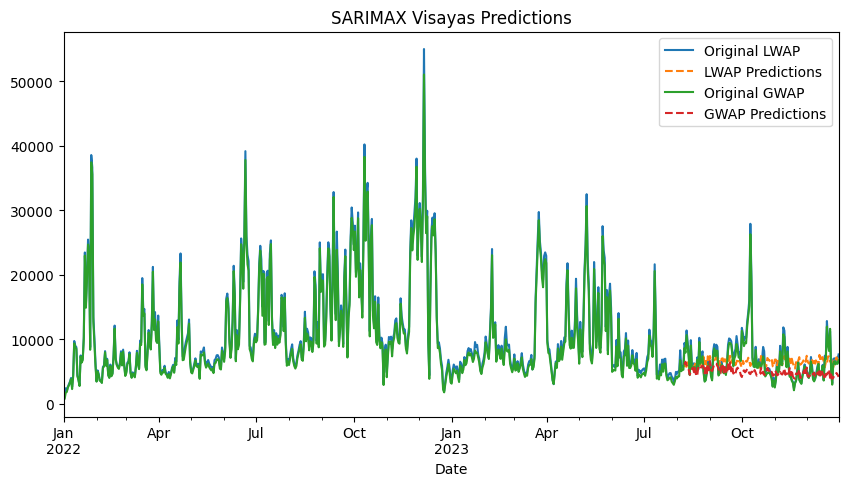

In [87]:
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original LWAP')
LWAP_predictions_inverse.plot(ax=ax, label='LWAP Predictions', linestyle='--')
GWAP.plot(ax=ax, label='Original GWAP')
GWAP_predictions_inverse.plot(ax=ax, label='GWAP Predictions', linestyle='--')
ax.set_title('SARIMAX Visayas Predictions')
ax.legend()
plt.show()

Applying inverse transformations - rolling

In [ ]:
all_predictions_rolling = pd.concat([gwap_rolling_predictions, lwap_rolling_predictions], axis=1)
all_predictions_rolling_inverse=boxcoxy_fit_loaded.inverse_transform(all_predictions_rolling)
all_predictions_rolling_inverse

In [ ]:
all_predictions_rolling_inverse_df = pd.DataFrame(all_predictions_rolling_inverse)
all_predictions_rolling_inverse_df.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)

GWAP_predictions_rolling_inverse = pd.DataFrame(all_predictions_rolling_inverse[:, 0], columns=['GWAP'])
GWAP_predictions_rolling_inverse = pd.concat([test_date,GWAP_predictions_rolling_inverse], axis=1)
GWAP_predictions_rolling_inverse.set_index('Date', inplace=True)
GWAP_predictions_rolling_inverse.index = pd.to_datetime(GWAP_predictions_rolling_inverse.index)
GWAP_predictions_rolling_inverse.index.freq='D'
GWAP_predictions_rolling_inverse = GWAP_predictions_inverse.squeeze()

LWAP_predictions_rolling_inverse = pd.DataFrame(all_predictions_rolling_inverse[:, 1], columns=['LWAP'])
LWAP_predictions_rolling_inverse = pd.concat([test_date,LWAP_predictions_rolling_inverse], axis=1)
LWAP_predictions_rolling_inverse.set_index('Date', inplace=True)
LWAP_predictions_rolling_inverse.index = pd.to_datetime(LWAP_predictions_rolling_inverse.index)
LWAP_predictions_rolling_inverse.index.freq='D'
LWAP_predictions_rolling_inverse = LWAP_predictions_rolling_inverse.squeeze()

In [ ]:
# Calculate MAE for the Visayas GWAP test set
mae_test = mean_absolute_error(GWAP_test_inversed, GWAP_predictions_rolling_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Visayas GWAP test set
rmse_test = mean_squared_error(GWAP_test_inversed, GWAP_predictions_rolling_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
GWAP.plot(ax=ax, label='Original Data')
GWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Visayas GWAP Predictions')
ax.legend()
plt.show()

In [ ]:
# Calculate MAE for the Visayas LWAP test set
mae_test = mean_absolute_error(LWAP_test_inversed, LWAP_predictions_rolling_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Visayas GWAP test set
rmse_test = mean_squared_error(LWAP_test_inversed, LWAP_predictions_rolling_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original Data')
LWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Visayas LWAP Predictions')
ax.legend()
plt.show()